<a href="https://colab.research.google.com/github/alexngocvu/Personal-Project/blob/main/Fraud_Real_Time_(colab_adapted).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving creditcard.csv to creditcard.csv
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206

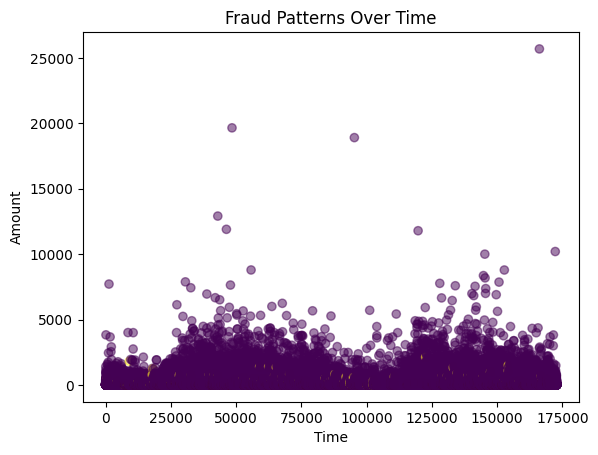

After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC Score: 0.9463

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9080


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9436

Sample Prediction: {'fraud_probability': 0.04480739310383797, 'is_fraud': np.False_}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Data Drift Detected: False


In [1]:
# Fraud Detection Model in Google Colab
# Install required libraries
!pip install pandas numpy matplotlib scikit-learn imbalanced-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# Step 1: Load the Data
# Note: Upload the 'creditcard.csv' file to Colab manually or use a URL if available
# For this example, assume the file is uploaded to Colab
# If you have a direct URL from Kaggle, you can use:
# df = pd.read_csv('URL_TO_CREDITCARD_CSV')
# For local upload in Colab:
from google.colab import files
uploaded = files.upload()  # Upload creditcard.csv
df = pd.read_csv('creditcard.csv')
print(df.head())

# Step 2: Exploratory Data Analysis (EDA)
plt.scatter(df['Time'], df['Amount'], c=df['Class'], alpha=0.5)
plt.title('Fraud Patterns Over Time')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

# Step 3: Data Preprocessing
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

# Step 4: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", pd.Series(y_res).value_counts())

# Step 5: Train and Evaluate Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Dictionary to store results
results = {}

for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    results[name] = {'classification_report': classification_report(y_test, y_pred, output_dict=True), 'roc_auc': roc_auc}

# Save the best model (XGBoost)
joblib.dump(models['XGBoost'], 'xgboost_model.pkl')

# Step 6: Simulated Real-Time Prediction (Replacing Flask API)
def predict_fraud(transaction, model, scaler):
    # transaction: dict with 'time', 'amount', and 'pca_features' (list of V1-V28)
    features = np.array([transaction['time']] + [transaction['amount']] + transaction['pca_features'])
    # Scale time and amount
    scaled_time_amount = scaler.transform([[features[0], features[1]]])
    features[0:2] = scaled_time_amount[0]
    # Predict
    fraud_prob = model.predict_proba([features])[0][1]
    return {'fraud_probability': float(fraud_prob), 'is_fraud': fraud_prob > 0.9}

# Example transaction
sample_transaction = {
    'time': 0,  # Example time
    'amount': 100.0,  # Example amount
    'pca_features': [0.1] * 28  # Example V1-V28 features
}
loaded_model = joblib.load('xgboost_model.pkl')
prediction = predict_fraud(sample_transaction, loaded_model, scaler)
print("\nSample Prediction:", prediction)

# Step 7: Detect Data Drift
from scipy.stats import ks_2samp

def detect_drift(new_data, old_data):
    p_values = []
    for col in new_data.columns:
        _, pval = ks_2samp(old_data[col], new_data[col])
        p_values.append(pval)
    return np.mean(p_values) < 0.05

# Simulate new data (using a subset of test data as example)
new_data = X_test.sample(frac=0.1, random_state=42)
drift_detected = detect_drift(new_data, X_train)
print("\nData Drift Detected:", drift_detected)